# Supervisor

Multi-agent supervisor

In [2]:
%%capture --no-stderr
%pip install -U langgraph lanchain_community langchain_ollama langchain_experimental

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("TAVILY_API_KEY")


## Create tools
An agent to do web research with a search engine, and one agent to create plots

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
/var/folders/wm/j89vyk052m5bvrvn1dhfyflr0000gn/T/ipykernel_16168/2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/wm/j89vyk052m5bvrvn1dhfyflr0000gn/T/ipykernel_16168/2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


### Create Agent Supervisor
Choosing the next worker node OR finish processing

In [3]:
from langgraph.graph import MessagesState

In [4]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

In [5]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_ollama import ChatOllama

members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOllama(model="llama3.1")


def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

## Construct Graph
The stat and worker nodes 

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="researcher")
        ]
    }


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]
    }


builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)

Connet all the edges in the graph.

In [7]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "supervisor")

graph = builder.compile()

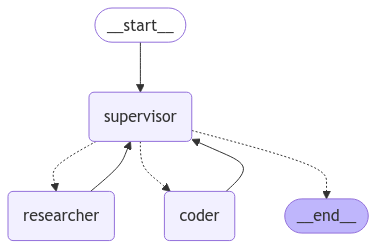

In [8]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

In [11]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----
(('coder:fd4e2149-3a38-0dc9-425a-bed225470434',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-22T06:00:37.13247Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'python_repl_tool', 'arguments': {'code': 'import math; print(math.sqrt(42))'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 3541123208, 'load_duration': 22171208, 'prompt_eval_count': 206, 'prompt_eval_duration': 1992000000, 'eval_count': 27, 'eval_duration': 1518000000}, id='run-45616498-1769-48b6-91f5-6252fc459632-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math; print(math.sqrt(42))'}, 'id': '6f4071ba-f17c-4155-90b0-42aef10bc72e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 206, 'output_tokens': 27, 'total_tokens': 233})]}})
----
(('coder:fd4e2149-3a38-0dc9-425a-bed225470434',), {'tools': {'messages': [Too